In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [9]:
def ecdf(data):
    '''Compute the x and y points to generate ecdf of data'''
    x = np.sort(data)
    y = np.arange(1, len(x)+1)/len(x)
    return x, y

def bs_replicated_1d(data,formula):
    '''compute a bs replicate of a 1 dimension data'''
    bs_sample = np.random.choice(data, size = len(data))
    return formula(bs_sample)

def draw_bs_reps(data, formula, size = 1):
    '''compute many bs replicates of data'''
    bs_replicate = np.empty(size)
    for i in range(size):
        bs_replicate[i] = bs_replicated_1d(data, formula)
        
    return bs_replicate

def perm_sample(data1, data2):
    data = np.concatenate((data1, data2))
    perm_sample = np.random.permutation(data)
    perm_sample1 = perm_sample[:len(data1)]
    perm_sample2 = perm_sample[len(data1):]
    return perm_sample1, perm_sample2

def draw_perm_replicate(data1, data2, func, size = 1):
    perm_repl = np.empty(size)
    for i in range(size):
        perm1, perm2 = perm_sample(data1, data2)
        perm_repl[i] = func(perm1, perm2)
        
    return perm_repl

def diff_of_mean(data1, data2):
    return np.mean(data1) - np.mean(data2)

In [3]:
fish_data = pd.read_csv('zebrafish_activity_bouts.csv', skiprows = 4)

In [4]:
fish_data.head()

,genotype,bout_length,fish
0,het,12.00,1
1,het,33.00,1
2,het,0.96,1
3,het,4.98,1
4,het,1.98,1


#### EDA: Plot ECDFs of active bout length
An active bout is a stretch of time where a fish is constantly moving. Plot an ECDF of active bout length for the mutant and wild type fish for the seventh night of their lives. The data sets are in the numpy arrays bout_lengths_wt and bout_lengths_mut. The bout lengths are in units of minutes.

In [8]:
#bout length of wild type
bout_lengths_wt = fish_data.loc[fish_data['genotype'] == 'wt', 'bout_length'].values
#bout length of mutant type
bout_lengths_mut = fish_data.loc[fish_data['genotype'] == 'mut', 'bout_length'].values
#bout length of heterozygotic type
bout_lengths_het = fish_data.loc[fish_data['genotype'] == 'het', 'bout_length'].values


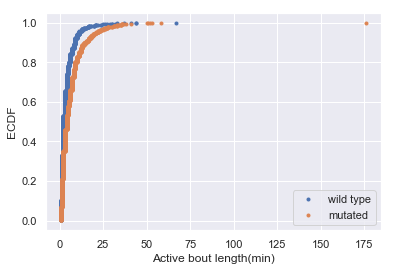

In [6]:
#getting values for ecdf
x_wt, y_wt = ecdf(bout_lengths_wt)
x_mut, y_mut = ecdf(bout_lengths_mut)

#plotting
_ = plt.plot(x_wt, y_wt, marker = '.', linestyle = 'none')
_ = plt.plot(x_mut, y_mut, marker = '.', linestyle = 'none')
_ = plt.legend(('wild type', 'mutated'), loc = 'lower right')
_ = plt.xlabel('Active bout length(min)')
_ = plt.ylabel('ECDF')
plt.show()

The bout lengths appear Exponentially distributed, which implies that exiting an active bout to rest is a Poisson process; the fish have no apparent memory about when they became active.

Computing the mean active bout length for wild type and mutant, with 95% bootstrap confidence interval.

In [7]:
np.random.seed(43)
# Compute mean active bout length
mean_wt = np.mean(bout_lengths_wt)
mean_mut = np.mean(bout_lengths_mut)

# Draw bootstrap replicates
bs_reps_wt = draw_bs_reps(bout_lengths_wt, np.mean, size=10000)
bs_reps_mut = draw_bs_reps(bout_lengths_mut, np.mean, size=10000)

# Compute 95% confidence intervals
conf_int_wt = np.percentile(bs_reps_wt, [2.5, 97.5])
conf_int_mut = np.percentile(bs_reps_mut, [2.5, 97.5])

# Print the results
print("""
wt:  mean = {0:.3f} min., conf. int. = [{1:.1f}, {2:.1f}] min.
mut: mean = {3:.3f} min., conf. int. = [{4:.1f}, {5:.1f}] min.
""".format(mean_wt, *conf_int_wt, mean_mut, *conf_int_mut))


wt:  mean = 3.874 min., conf. int. = [3.6, 4.1] min.
mut: mean = 6.543 min., conf. int. = [6.1, 7.0] min.



# Hypothesis Testing

Test the hypothesis that the heterozygote and wild type bout lengths are identically distributed using a permutation test.

## Pipeline	for	hypothesis	testing
1.Clearly	state	the	null	hypothesis
2.Define	your	test	statistic
3.Generate	many	sets	of	simulated	data	assuming	the	null	hypothesis is	true 
4.Compute	the	test	statistic	for	each	simulated	dataset 
5.The	p-value	is	the	fraction of	your simulated	data	sets	for	which	the test	statistic	is	at	least as extreme as	for	the	real data

In [12]:
np.random.seed(42)
# original difference of mean in heterozygote and wild type
diff_of_mean_bout = np.mean(bout_lengths_het) - np.mean(bout_lengths_wt)
#generating data under the assumption that null hypothesis is true
perm_rep_mean = draw_perm_replicate(bout_lengths_het, bout_lengths_wt, diff_of_mean, size = 10000)
p_value = np.sum(perm_rep_mean >=diff_of_mean_bout)/len(perm_rep_mean)
p_value

0.0012

A p-value of 0.0012 suggests that the observed difference in means is unlikely to occur if heterozygotic and wild type fish have active bout lengths that are identically distributed.

# Bootstrap hypothesis test
The permutation test has a pretty restrictive hypothesis, that the heterozygotic and wild type bout lengths are identically distributed. Now, use a bootstrap hypothesis test to test the hypothesis that the means are equal, making no assumptions about the distributions.

In [14]:
np.random.seed(42)
mean_bout_length = np.mean(np.concatenate((bout_lengths_het, bout_lengths_wt)))
wt_shifted = bout_lengths_wt - np.mean(bout_lengths_wt) + mean_bout_length
het_shifted = bout_lengths_het - np.mean(bout_lengths_het) + mean_bout_length
bs_reps_wt = draw_bs_reps(wt_shifted, np.mean, size = 10000)
bs_reps_het = draw_bs_reps(het_shifted, np.mean, size = 10000)
bs_reps = bs_reps_het - bs_reps_wt

p = np.sum(bs_reps >= diff_of_mean_bout)/len(bs_reps)
p

0.0005

Since we got a smaller value than significance level so het and wt fish are different